# 搭建CNN


In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten , Dense
from keras import backend as K
from imutils import paths

class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)
        # if we are using "channels last", update the input shape
        if K.image_data_format() == "channels_first":   #for tensorflow
            inputShape = (depth, height, width)
        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5),padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        #second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

/home/weijia.wu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

zip([x.name for x in model.layers], range(len(model.layers)))

NameError: name 'model' is not defined

In [1]:
from keras.layers.core import Activation
from keras.layers.core import Flatten , Dense
from keras import backend as K
from imutils import paths
from keras.layers import Input, concatenate
from keras.models import Model,load_model
from keras import regularizers
from keras.applications import VGG16


base_model = VGG16(input_shape=(224,224,3),include_top=False, weights='imagenet')

/home/weijia.wu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import applications
from keras.layers import Dropout, Flatten, Dense
from keras import Model
from keras.models import Sequential

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(12, activation='softmax'))

        
model = Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [3]:
base_model.output.shape

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(512)])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# 一些全局变量的声明

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import sys
sys.path.append('..')


# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 35
INIT_LR = 1e-3
BS = 32
CLASS_NUM = 12
norm_size = 224



# 导入数据

In [17]:
def load_data(path):
    print('[INFO] loading images...')
    data = []
    labels = []
    # grad the image paths and randomly shuffle them
    imagePaths = sorted(list(paths.list_images(path)))
#     print(imagePaths)
    random.seed(42)
    random.shuffle(imagePaths)
    # loop over the imput image 
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
#         print(image)
        image = cv2.resize(image, (norm_size,norm_size))
        image = img_to_array(image)
        data.append(image)
        
        # extract the class label from the image path and update the label list
        label = str(imagePath.split(os.path.sep)[-2])
#         print(label)
        labels.append(label)
        
    # scale the raw pixel intensities to the range(0,1)
    data = np.array(data,dtype="float") / 255.0
    labels = np.array(labels)
    
    labels = to_categorical(labels,num_classes=CLASS_NUM)
    return data,labels

# 评价函数（正确率）

In [4]:
def test(args):
    image = cv2.imread(args)
    img = cv2.imdecode(np.fromfile(args, dtype=np.uint8), -1)
    orig = image.copy()
    # pre-process the image for classification
    image = cv2.resize(image, (norm_size, norm_size))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
     
    # classify the input image
    result = model.predict(image)[0]
    proba = np.max(result)
    label = int(np.where(result==proba)[0])
    return label

def score_function(path):
    files = os.listdir(path)
    sun = len(files)
    print(sun)
    score = 0
    for x in files:
        pathh = path + x
        picture_name = os.listdir(pathh)
        picture_number = len(picture_name)
        right_number = 0
        for y in picture_name:
            picture_path = pathh + '/' + y
            print(picture_path)
            result = test(picture_path)
            print(result , x)
            if result == int(x):
                right_number = right_number + 1
        score = float(right_number) / float(picture_number)  + score
        
    score = score/float(sun)
    return score
    
score = score_function('/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/')
score

12
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910092816对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180831150301对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910092732对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910093349对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910091904对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910093110对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180913104812对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180911105054对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910100037对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_d

(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910094213对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180911142020对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910093553对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910095259对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910092250对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180831144713对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910092110对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910093933对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180831160918对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset

(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910095417对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180831150325对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180912161839对照样本.jpg
(4, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910094131对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910095047对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910093401对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180913105430对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180915104643对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910093459对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/

(9, '9')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/9/涂层开裂20180905140826对照样本.jpg
(9, '9')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/9/涂层开裂20180905150402对照样本.jpg
(9, '9')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/9/涂层开裂20180905161432对照样本.jpg
(9, '9')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/拖烂20180831105210对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/油渣20180907160501对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/纹粗20180907162439对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/纹粗20180907162040对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/变形20180906142153对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/铝屑20180907150114对照样本.jpg
(10, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/trai

(6, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/杂色20180903153655对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/划伤20180912101002对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180901103810对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/打白点20180907144316对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/拖烂20180831105400对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180901103136对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180829165925对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180901104014对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/纹粗20180830142251对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset

(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/铝屑20180911142100对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180914160649对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/纹粗20180907162049对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/纹粗20180907162416对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180905141153对照样本.jpg
(9, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/喷涂碰伤20180830162202对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/油渣20180906141644对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180901104206对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/纹粗20180830141638对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/datase

(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180908105549对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180830135542对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901091333对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901091344对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180912152819对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901093336对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901092338对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180829171852对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180830140608对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底2018090109451

(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180830162452对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901092122对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901091802对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180908105408对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180908105626对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180908095703对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180912160714对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901091854对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180829174103对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底2018090109494

(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901094526对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901091554对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901095028对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180912153911对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180912163049对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180830135239对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180908104252对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180910103001对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180908103742对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底2018083016304

(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905092521对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905095214对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905093700对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905092444对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905093116对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905094943对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905091502对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905092218对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180912141640对照样本.jpg
(10, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤201809071544

(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180831105957对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180831110816对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180907103928对照样本.jpg
(10, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180912095828对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180915104837对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180831110501对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180901140636对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180831160713对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180901104335对照样本.jpg
(11, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180915105

(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901141536对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901101731对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901141803对照样本.jpg
(2, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901101751对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901141824对照样本.jpg
(2, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901135935对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901101133对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901141448对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901135426对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉2018090110165

(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180830134402对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831102843对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831104025对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831102055对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831104154对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180830142107对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831104236对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831104106对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831101421对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电201

(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180912161637对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180912164453对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180912152006对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180830152742对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180912163144对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180830165224对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180912151950对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180908090827对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180906102812对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮2018091216533

(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/3/横条压凹20180903111501对照样本.jpg
(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/3/横条压凹20180903105422对照样本.jpg
(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/3/横条压凹20180903103125对照样本.jpg
(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915142856对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915144919对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915162832对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914144149对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915143306对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914154639对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091

(10, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915151417对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915153117对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914152844对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914110622对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913150934对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915151941对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915144224对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914142514对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915151226对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常201809151604

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914144614对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913165145对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914142413对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914090830对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915160936对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915150933对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915144853对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915143015对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914143032对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091415410

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915160725对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914140942对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180912140831对照样本.jpg
(10, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914094202对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914094342对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913154804对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915163706对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914091621对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914144625对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常201809131502

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913164415对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913144224对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915155633对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913150455对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914141553对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914110733对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914102524对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914105740对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913145819对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091214271

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913173401对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914092229对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913142433对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914103644对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913150046对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915155504对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913154817对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915153705对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913173109对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091515383

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914111207对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915150915对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915153051对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915143954对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914094146对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914105014对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914101257对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915150352对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915145202对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091515055

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915154558对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914141046对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914105711对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913165320对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915143858对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914135812对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914102558对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913151948对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914111132对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091414111

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915153827对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915143812对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915143317对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914090847对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915140132对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914143347对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914090615对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913142317对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913135817对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091516245

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915153809对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915161323对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913171449对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914140441对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915164207对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913172347对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914110708对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915161724对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915163546对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091315361

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915142814对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913152915对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914102722对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913150848对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914145546对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914092610对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914102224对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914142318对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913172400对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091414560

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913165224对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913143623对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914101036对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914101218对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913144323对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913145835对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914141413对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913142201对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914142436对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091514500

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914101909对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913152258对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914104615对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915140056对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913140000对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913171059对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915145924对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913162945对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915144324对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091316352

0.9629189843355245

# 自定义评价函数

In [18]:
import tensorflow as tf
def metric_LB(y_true,y_pred):
    y_pred_label = K.argmax(y_pred,axis=-1)
    y_pred_ = K.one_hot(y_pred_label,num_classes=12)
    tp_fp = K.sum(y_pred_,axis=0)
    n = tf.count_nonzero(tp_fp,dtype='float32')
    tp = K.sum(y_true*y_pred_,axis=0)
    return K.sum(tp/(tp_fp+1e-6))/n

# 评价函数（准确率）

In [24]:
from imutils import paths
def test(args):
    image = cv2.imread(args)
    img = cv2.imdecode(np.fromfile(args, dtype=np.uint8), -1)
    orig = image.copy()
    # pre-process the image for classification
    image = cv2.resize(image, (norm_size, norm_size))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
     
    # classify the input image
    result = model.predict(image)[0]
    proba = np.max(result)
    label = int(np.where(result==proba)[0])
    return label

def score_function_acc(path,train_y):
    files = os.listdir(path)
    sun = len(files)
    print(sun)
    right_number = []
    number = [0,0,0,0,0,0,0,0,0,0,0,0]
    for x in range(sun):
        for y in train_y:
            if x == y:
                number[x] = number[x] + 1

    return number
def score_function_right(path):
    files = os.listdir(path)
    sun = len(files)
    print(sun)
    number = [0,0,0,0,0,0,0,0,0,0,0,0]
    for x in files:
        pathh = path + x
        picture_name = os.listdir(pathh)
        picture_number = len(picture_name)
        for y in picture_name:
            picture_path = pathh + '/' + y
            print(picture_path)
            result = test(picture_path)
            print(result , x)
            if result == int(x):
                number[result] = number[result] + 1
    return number

train_file_path = "/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data"
path = "/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/"
# trainX,trainY = load_data(train_file_path)
# train_y = model.predict(trainX)
y_pred_label = np.argmax(train_y,axis=1)
number = score_function_acc(train_file_path,y_pred_label)
number_right = score_function_right(path)
# y_pred_label
print(number)
print(number_right)
# train_y.shape
sun = 0
for i in range(12):
    sun = float(right_number[i])/float(number[i]) + sun
sun = sun/12
print(sun)

12
12
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910092816对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180831150301对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910092732对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910093349对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910091904对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910093110对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180913104812对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180911105054对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910100037对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/trai

(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910093553对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910095259对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910092250对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180831144713对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910092110对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910093933对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180831160918对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910095849对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180831144529对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset

(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180912161839对照样本.jpg
(4, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910094131对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910095047对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910093401对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180913105430对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180915104643对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180910093459对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180912100550对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/10/脏点20180831143909对照样本.jpg
(10, '10')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/

(9, '9')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/9/涂层开裂20180905150402对照样本.jpg
(9, '9')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/9/涂层开裂20180905161432对照样本.jpg
(9, '9')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/拖烂20180831105210对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/油渣20180907160501对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/纹粗20180907162439对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/纹粗20180907162040对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/变形20180906142153对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/铝屑20180907150114对照样本.jpg
(10, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/划伤20180912100946对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/tra

(6, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/杂色20180903153655对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/划伤20180912101002对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180901103810对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/打白点20180907144316对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/拖烂20180831105400对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180901103136对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180829165925对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180901104014对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/纹粗20180830142251对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset

(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/划伤20180911140930对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/铝屑20180911142100对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180914160649对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/纹粗20180907162049对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/纹粗20180907162416对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180905141153对照样本.jpg
(9, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/喷涂碰伤20180830162202对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/油渣20180906141644对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/11/碰凹20180901104206对照样本.jpg
(11, '11')
/home/weijia.wu/workspace/Kaggle/rolled_steel/datase

(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901095326对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180908105549对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180830135542对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901091333对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901091344对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180912152819对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901093336对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901092338对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180829171852对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底2018083014060

(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180912160157对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180912164032对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180830162452对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901092122对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901091802对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180908105408对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180908105626对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180908095703对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180912160714对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底2018090109185

(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901094319对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180908103931对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901094526对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901091554对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180901095028对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180912153911对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180912163049对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180830135239对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底20180908104252对照样本.jpg
(5, '5')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/5/漏底2018091010300

(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905094102对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905093918对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905092521对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905095214对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905093700对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905092444对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905093116对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905094943对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤20180905091502对照样本.jpg
(6, '6')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/6/碰伤2018090509221

(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180911104852对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180831105744对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180901135948对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180831105957对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180831110816对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180907103928对照样本.jpg
(10, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180912095828对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180915104837对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花20180831110501对照样本.jpg
(2, '2')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/2/擦花201809011406

(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901101356对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901101222对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901101631对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901140917对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901141536对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901101731对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901141803对照样本.jpg
(2, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901101751对照样本.jpg
(8, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉20180901141824对照样本.jpg
(2, '8')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/8/凸粉2018090113593

(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831102813对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831102939对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831102726对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831103945对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831104052对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180830134402对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831102843对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831104025对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电20180831102055对照样本.jpg
(1, '1')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/1/不导电201

(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180830165314对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180830164102对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180830164233对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180830165146对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180830165155对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180912161637对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180912164453对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180912152006对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮20180830152742对照样本.jpg
(4, '4')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/4/桔皮2018091216314

(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/3/横条压凹20180903105949对照样本.jpg
(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/3/横条压凹20180903111207对照样本.jpg
(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/3/横条压凹20180903101522对照样本.jpg
(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/3/横条压凹20180903101854对照样本.jpg
(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/3/横条压凹20180903103141对照样本.jpg
(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/3/横条压凹20180903111119对照样本.jpg
(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/3/横条压凹20180903111501对照样本.jpg
(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/3/横条压凹20180903105422对照样本.jpg
(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/3/横条压凹20180903103125对照样本.jpg
(3, '3')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913135917对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915154327对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914144601对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913162659对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915143258对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914103550对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913142117对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915145934对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180912142729对照样本.jpg
(10, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常201809151514

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914111030对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914145457对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914100136对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914145420对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914140903对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914105942对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915164316对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914144815对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914140428对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091110224

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914102140对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913152611对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914101015对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914144526对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913142520对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915160911对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915162114对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915145449对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915161028对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091516135

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914144842对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914104820对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915163622对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913142407对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914093834对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913153132对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913150033对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914105925对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915165056对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091415172

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913171613对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915162542对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914092451对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913165617对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915143330对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913144901对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914104729对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914154449对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915151525对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091414083

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180911102026.jpg
(11, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914091405对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915152327对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914145257对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914103145对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914091003对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915144807对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914143004对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913150640对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915143938对照

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914103127对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915164800对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914100150对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914100346对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913141907对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914091648对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914090439对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914100330对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914145556对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091414064

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913150424对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915164249对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915143800对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913142217对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914143123对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915144243对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914155746对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915162809对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914154412对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091516033

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913152129对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915145635对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914142736对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913173348对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915153613对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914151828对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913142448对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915151502对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913154210对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091410182

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915165854对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914144220对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913154447对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915144315对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915164222对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913170403对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915144148对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915150613对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915164131对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091414054

(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915143826对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915164237对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914092143对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913135946对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914100535对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914101006对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914142034对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915150343对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913154131对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常2018091409242

(11, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913142650对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913153511对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915155451对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914103112对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180913145056对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914105800对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915151107对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180914094226对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常20180915150032对照样本.jpg
(0, '0')
/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data/0/正常201809151401

NameError: name 'right_number' is not defined

In [25]:
print(number)
print(number_right)

[1015, 37, 127, 48, 89, 247, 75, 54, 42, 37, 223, 175]
[1010, 37, 121, 47, 87, 247, 73, 53, 41, 35, 203, 157]


# 训练数据

In [25]:
def train(aug,trainX,trainY,testX,testY):
    # initialize the model
    print("[INFO] compiling model ...")
#     model = ResNet50(width=norm_size,height = norm_size,depth=3 , classes=CLASS_NUM)
#     opt = Adam(lr=INIT_LR,decay=INIT_LR / EPOCHS)
#     model.compile(loss="categorical_crossentropy", optimizer=opt,
#         metrics=["accuracy"])

    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4, decay=1e-6),
              metrics=['accuracy', metric_LB])
    #train the network
    print("[INFO] training network...")
    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
        validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
        epochs=EPOCHS, verbose=1,callbacks=[checkpoint])

    # save the model to disk
    print("[INFO] serializing network...")
    model.save('/home/weijia.wu/workspace/Kaggle/rolled_steel/Net_Gangecai/result/rolled_steel.model')
    
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    N = EPOCHS
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy on rolled_steel classifier")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("/home/weijia.wu/workspace/Kaggle/rolled_steel/Net_Gangecai/result/VGG_weijiawu2")

# 设置实时保存优化器状态

In [26]:
from keras.callbacks import ModelCheckpoint
filepath = '/home/weijia.wu/workspace/Kaggle/rolled_steel/Net_Gangecai/result/VGG_weijiawu2.model'
checkpoint = ModelCheckpoint(
    filepath, 
    monitor='val_metric_LB', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='max', 
    period=1
)

# 导入数据并且开始训练

[INFO] compiling model ...
[INFO] training network...
Epoch 1/35
45/44 [==============================] - 26s 586ms/step - loss: 0.1570 - acc: 0.9534 - metric_LB: 0.9334 - val_loss: 0.1463 - val_acc: 0.9499 - val_metric_LB: 0.9264
Epoch 2/35
45/44 [==============================] - 22s 490ms/step - loss: 0.1116 - acc: 0.9586 - metric_LB: 0.9417 - val_loss: 0.2433 - val_acc: 0.9359 - val_metric_LB: 0.9209
Epoch 3/35
45/44 [==============================] - 22s 491ms/step - loss: 0.1842 - acc: 0.9417 - metric_LB: 0.9115 - val_loss: 0.2544 - val_acc: 0.9053 - val_metric_LB: 0.8451
Epoch 4/35
45/44 [==============================] - 22s 491ms/step - loss: 0.1425 - acc: 0.9474 - metric_LB: 0.9246 - val_loss: 0.1431 - val_acc: 0.9471 - val_metric_LB: 0.9092
Epoch 5/35
45/44 [==============================] - 22s 491ms/step - loss: 0.1404 - acc: 0.9560 - metric_LB: 0.9357 - val_loss: 0.1366 - val_acc: 0.9443 - val_metric_LB: 0.9101
Epoch 6/35
45/44 [==============================] - 22s 492ms

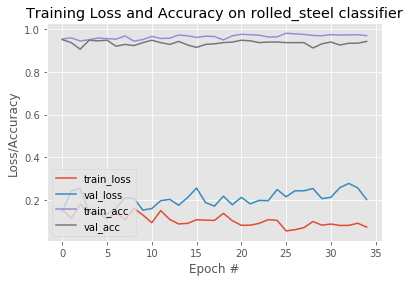

In [28]:
import os
from sklearn.model_selection import train_test_split
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"  


#python train.py --dataset_train ../../traffic-sign/train --dataset_test ../../traffic-sign/test --model traffic_sign.model
if __name__=='__main__':
    train_file_path = "/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data"
#     trainX,trainY = load_data(train_file_path)
    trainX,testX,trainY,testY= train_test_split(trainX,trainY,test_size=0.2,random_state=0)
    # construct the image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
        height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
        horizontal_flip=True, fill_mode="nearest")
    train(aug,trainX,trainY,testX,testY)

In [9]:
# import the necessary packages
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import imutils
import cv2

norm_size = 224

def predict(args):
    # load the trained convolutional neural network
    print("[INFO] loading network...")
#     model = load_model("/home/weijia.wu/workspace/Kaggle/rolled_steel/LeNet_Gangecai/traffic_sign.model")
    
    #load the image
    image = cv2.imread(args)
    orig = image.copy()
     
    # pre-process the image for classification
    image = cv2.resize(image, (norm_size, norm_size))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
     
    # classify the input image
    result = model.predict(image)[0]
    #print (result.shape)
    
    proba = np.max(result)
    print(proba)
    label = int(np.where(result==proba)[0])
    print(label)
    label = "{}: {:.2f}%".format(label, proba * 100)
    print(label)
    
    if 1:    
        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (0, 255, 0), 2)       
        # show the output image
        cv2.imwrite("out1.jpg", output)
#         cv2.imshow("Output", output)
#         cv2.waitKey(0)

        
        
#python predict.py --model traffic_sign.model -i ../2.png -s
if __name__ == '__main__':
    predict("/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/test_data/256.jpg")

[INFO] loading network...
0.6893098
0
0: 68.93%


In [ ]:
from keras.models import load_model
# model = load_model("/home/weijia.wu/workspace/Kaggle/rolled_steel/Net_Gangecai/result/VGG_weijiawu1.h5")
model.load_weights("/home/weijia.wu/workspace/Kaggle/rolled_steel/Net_Gangecai/result/VGG_weijiawu2.model")

In [7]:
print(len(files))

438


In [32]:
import os
import cv2
path = "/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/test_data/"
# model = load_model("/home/weijia.wu/workspace/Kaggle/rolled_steel/LeNet_Gangecai/traffic_sign.model")

#!/usr/bin/env python
# coding=utf-8
 
from xlwt import *
#需要xlwt库的支持
#import xlwt
file = Workbook(encoding = 'utf-8')
#指定file以utf-8的格式打开
table = file.add_sheet('data')
#指定打开的文件名
ImageId = []
Label = []
def test(args):
    image = cv2.imread(args)
    orig = image.copy()
    # pre-process the image for classification
    image = cv2.resize(image, (norm_size, norm_size))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
     
    # classify the input image
    result = model.predict(image)[0]
    proba = np.max(result)
    label = int(np.where(result==proba)[0])
    return label

files = os.listdir(path)

for i in files:
    result = test(path + i)
    ImageId.append(i)
    if result == 0:
        defa = 'norm'
    else:
        defa = 'defect' + str(result)
    Label.append(defa)
#     print(i , result)
#     print(defa)
          
print(ImageId)
print(Label)


['81.jpg', '132.jpg', '289.jpg', '166.jpg', '199.jpg', '3.jpg', '154.jpg', '76.jpg', '373.jpg', '185.jpg', '139.jpg', '14.jpg', '116.jpg', '236.jpg', '16.jpg', '265.jpg', '69.jpg', '181.jpg', '391.jpg', '151.jpg', '380.jpg', '164.jpg', '368.jpg', '68.jpg', '301.jpg', '410.jpg', '204.jpg', '381.jpg', '386.jpg', '388.jpg', '29.jpg', '438.jpg', '309.jpg', '228.jpg', '351.jpg', '34.jpg', '0.jpg', '294.jpg', '311.jpg', '307.jpg', '74.jpg', '45.jpg', '100.jpg', '360.jpg', '213.jpg', '394.jpg', '223.jpg', '316.jpg', '336.jpg', '260.jpg', '123.jpg', '21.jpg', '270.jpg', '104.jpg', '201.jpg', '149.jpg', '248.jpg', '197.jpg', '175.jpg', '382.jpg', '344.jpg', '308.jpg', '271.jpg', '238.jpg', '144.jpg', '324.jpg', '42.jpg', '89.jpg', '346.jpg', '52.jpg', '186.jpg', '28.jpg', '257.jpg', '312.jpg', '298.jpg', '375.jpg', '134.jpg', '216.jpg', '155.jpg', '117.jpg', '383.jpg', '63.jpg', '87.jpg', '396.jpg', '229.jpg', '84.jpg', '124.jpg', '200.jpg', '162.jpg', '356.jpg', '46.jpg', '419.jpg', '137.jpg',

In [33]:
import pandas as pd
submissions=pd.DataFrame({"ImageId": ImageId,
                         "Label": Label})
submissions.to_csv("DR3.csv", index=False, header=None)

# 可视化模型

In [10]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
zip([x.name for x in model.layers], range(len(model.layers)))

[('input_3', 0),
 ('block1_conv1', 1),
 ('block1_conv2', 2),
 ('block1_pool', 3),
 ('block2_conv1', 4),
 ('block2_conv2', 5),
 ('block2_pool', 6),
 ('block3_conv1', 7),
 ('block3_conv2', 8),
 ('block3_conv3', 9),
 ('block3_pool', 10),
 ('block4_conv1', 11),
 ('block4_conv2', 12),
 ('block4_conv3', 13),
 ('block4_pool', 14),
 ('block5_conv1', 15),
 ('block5_conv2', 16),
 ('block5_conv3', 17),
 ('block5_pool', 18),
 ('sequential_2', 19)]

In [6]:
model2 = Model(model.input, [model.layers[18].output, model.output])

[3.5699270e-06 8.2900894e-01 1.1105484e-03 8.2784148e-08 1.4069619e-08
 2.5165206e-02 1.2852265e-02 4.2141639e-02 2.6142444e-02 4.6512358e-07
 6.3574873e-02 2.2035437e-10]


ValueError: Dimensions must be equal, but are 512 and 1000 for 'lambda_7/Mul' (op: 'Mul') with input shapes: [?,7,7,512], [1,1000].

<Figure size 432x288 with 0 Axes>

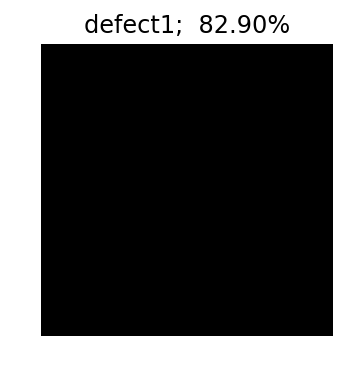

In [38]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.layers.core import Lambda
import imutils
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.gray()
plt.figure(figsize=(12, 14))
for i in range(4):
    img = cv2.imread('/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/test/%d.jpg' % i)
    img = cv2.resize(img, (224, 224))
    image = img.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    out, prediction = model2.predict(image)
    prediction = prediction[0]
    print(prediction)
    out = out[0]
    proba = np.max(prediction)
    label = int(np.where(prediction==proba)[0])
    
    if label == 0:
        label = 'norm'
    else:
        label = 'defect' + str(label)
        

#     print('Predicted class:')
#     print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.title(label + ';  %.2f%%' % (proba*100))
    plt.imshow(out[:,:,9])
    
#     predicted_class = np.argmax(prediction)
    cam, heatmap = grad_cam(base_model, img, np.argmax(out), "block5_conv3")
#     cv2.imwrite(i + "gradcam.jpg", cam)

In [37]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def grad_cam(input_model, image, category_index, layer_name):
    model = Sequential()
    model.add(input_model)

    nb_classes = 1000
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
    conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap